In [1]:
from fastai.vision.all import *

from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.simclr import *

In [2]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs, resize, size = 256, 256, 224

encoder = create_encoder("tf_mobilenetv3_small_minimal_100.in1k", n_in=3, pretrained=False) # a timm encoder


In [5]:
dls = get_dls(resize, bs)
model = create_simclr_model(encoder)

In [6]:
aug_pipelines = get_simclr_aug_pipelines(size, rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

In [7]:
cbs=[SimCLR(aug_pipelines)]

In [8]:
learn = Learner(dls, model, cbs=cbs)

In [9]:
learn.to_fp16()

/home/dnth/anaconda3/envs/fastai_ssl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dnth/anaconda3/envs/fastai_ssl/lib/python3.10/site-packages/timm/layers/conv2d_same.py:27: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/aten/src/ATen/native/cu

SuggestedLRs(valley=0.0002754228771664202)

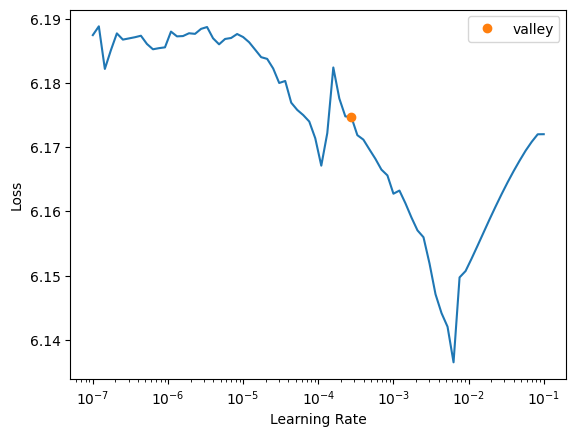

In [10]:
learn.lr_find()

In [ ]:
lr,wd,epochs=1e-3,1e-2,100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

In [ ]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.model.to('cpu')

In [ ]:
import torch.onnx
torch.onnx.export(learn.model.encoder,
                 torch.rand(1, 3, 224, 224, requires_grad=True),
                 "simclr.onnx",
                 export_params=True,
                 opset_version=16,
                 do_constant_folding=True,
                 input_names=['input'],
                 output_names=['output']
)